# Chapter 2: End-to-End Machine Learning Project

Bab ini memandu kita melalui proyek real-world dari awal hingga akhir, yaitu membangun model untuk memprediksi harga rumah di California menggunakan data sensus. Bab ini sangat praktis dan menunjukkan langkah-langkah utama yang harus diikuti dalam sebagian besar proyek Machine Learning.

## Kerangka Proyek

Berikut adalah langkah-langkah utama yang akan kita lalui

1. Memahami Gambaran Besar: Mendefinisikan tujuan bisnis dan membingkai masalah.
2. Mendapatkan Data: Mengunduh dan memuat data.
3. Eksplorasi dan Visualisasi Data: Memahami data lebih dalam untuk mendapatkan wawasan.
4. Mempersiapkan Data: Membersihkan dan mentransformasi data agar siap untuk algoritma ML.
5. Memilih dan Melatih Model: Memilih beberapa model yang menjanjikan dan melatihnya.
6. Fine-Tuning Model: Menyesuaikan hyperparameter untuk mendapatkan model terbaik.
7. Menyajikan Solusi: Meringkas hasil dan temuan.
8. Meluncurkan dan Memelihara Sistem: Men-deploy model ke produksi dan memonitornya.



### 1. Memahami Gambaran Besar

* Tujuan Bisnis: Output dari model kita (prediksi harga median rumah di suatu distrik) akan menjadi masukan untuk sistem lain yang akan menentukan apakah layak berinvestasi di area tersebut atau tidak.
* Pembingkaian Masalah:
  - Supervised Learning: Ya, karena kita memiliki data berlabel (harga rumah).
  - Tugas Regresi: Ya, karena kita akan memprediksi nilai numerik (harga).
  - Batch Learning: Ya, karena kita tidak memerlukan sistem yang beradaptasi dengan data baru secara cepat.
* Ukuran Kinerja: Metrik yang umum untuk regresi adalah Root Mean Square Error (RMSE). RMSE memberikan gambaran tentang seberapa besar kesalahan yang dibuat sistem dalam prediksinya, dengan memberikan bobot lebih pada kesalahan besar.

### 2. Mendapatkan Data
Kita akan mengunduh dataset California Housing Prices. Penting untuk mengotomatiskan proses ini agar mudah mendapatkan data terbaru.

In [ ]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("Chapter 2")
HOUSING_URL = DOWNLOAD_ROOT + "Chapter 2/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

D:\temp\ipykernel_2956\216993542.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


### 3. Eksplorasi dan Visualisasi Data

Setelah data dimuat, langkah pertama adalah melihat strukturnya. Kita menggunakan head(), info(), dan describe() untuk mendapatkan gambaran awal. Penting juga untuk membuat test set sebelum melakukan eksplorasi mendalam untuk menghindari data snooping bias.

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# Membuat kategori pendapatan untuk stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
# Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Hapus kolom income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

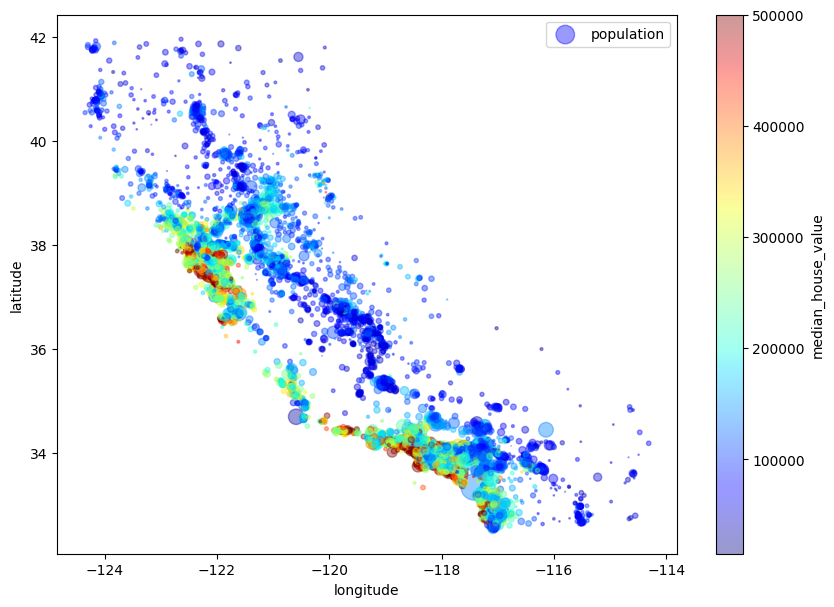

In [11]:
# Visualisasi data geografis\n",
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Visualisasi menunjukkan bahwa harga rumah sangat terkait dengan lokasi (misalnya, dekat laut) dan kepadatan populasi.

In [12]:

from sklearn.preprocessing import OrdinalEncoder

housing_encoded = housing.copy()

encoder = OrdinalEncoder()
housing_encoded['ocean_proximity'] = encoder.fit_transform(housing_encoded[['ocean_proximity']])

corr_matrix = housing_encoded.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
ocean_proximity       0.076936
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


Fitur yang paling berkorelasi dengan harga rumah adalah pendapatan median (median_income).

### 4. Mempersiapkan Data
Langkah ini melibatkan pembersihan data (mengatasi nilai yang hilang), menangani atribut kategorikal, dan penskalaan fitur. Sebaiknya semua transformasi ini ditulis dalam fungsi atau pipeline agar dapat digunakan kembali.

Kita akan membuat pipeline menggunakan ColumnTransformer dari Scikit-Learn untuk menerapkan transformasi yang berbeda pada kolom numerik dan kategorikal.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

### 5. Memilih dan Melatih Model
Setelah data siap, saatnya melatih beberapa model. Kita akan mencoba Regresi Linear, Pohon Keputusan (Decision Tree), dan Random Forest.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Melatih model Regresi Linear
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

# Melatih model Decision Tree
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

# Melatih model Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Linear Regression RMSE:", lin_rmse_scores.mean())
print("Decision Tree RMSE:", tree_rmse_scores.mean())
print("Random Forest RMSE:", forest_rmse_scores.mean())

Linear Regression RMSE: 69204.32275494764
Decision Tree RMSE: 69081.361562518
Random Forest RMSE: 49432.12678796127


Berdasarkan skor RMSE, Random Forest adalah model yang paling menjanjikan.

### 6. Fine-Tuning Model
Sekarang kita fokus pada model terbaik (Random Forest) dan mencoba menemukan kombinasi hyperparameter terbaik menggunakan GridSearchCV.

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
print("Best params:", grid_search.best_params_)

Best params: {'max_features': 8, 'n_estimators': 30}


Setelah menemukan hyperparameter terbaik, kita bisa menganalisis pentingnya setiap fitur dan mengevaluasi model final pada test set

In [16]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
from sklearn.metrics import mean_squared_error
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print("Final RMSE:", final_rmse)

Final RMSE: 47859.544319108194
